# Partie 1: Spark Streaming &amp; API Twitter ( covid19 ) : 

In [1]:
# localiser Spark sur notre machine locale à l'aide de la bibliothèque findspark,
import findspark
findspark.init()
import pyspark

In [2]:
# import necessary packages
from pyspark import SparkContext   # SparkContext est le point d'entrée de toute fonctionnalité de spark.
from pyspark.streaming import StreamingContext # pour traiter des flux de données qui arrivent en continu
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [3]:
# SparkContext est le point d'entrée pour toutes les fonctions Spark
sc = SparkContext()
# we initiate the StreamingContext with 10 second batch interval. #next we initiate our sqlcontext
ssc = StreamingContext(sc, 10) 
sqlContext = SQLContext(sc)

In [4]:
# initiate streaming text from a TCP (socket) source:
socket_stream = ssc.socketTextStream("192.168.1.102", 5555)
# lines of tweets with socket_stream window of size 60, or 60 #seconds windows of time
lines = socket_stream.window(60) 

Pour enregistrer le nombre de balises, nous avons créé un objet namedtuple. Ensuite, nous avons utilisé flatmap() pour générer un tableau de tweets. Nous utilisons des fonctions lambda car elles nécessitent moins de mémoire et s'exécutent plus rapidement. Nous filtrons ensuite les tweets qui ne commencent pas par #. La fonction foreachRDD() dans pySpark est une fonction importante qui permet un traitement plus rapide des RDD. Il est appliqué à chaque RDD pour le convertir en une trame de données et est ensuite stocké dans une table temporaire intitulée « tweets ».

In [5]:
# nettoyé les tweets qui commencent par # et enregistrer les 10 premiers tweets dans une table SQL temporaire
from collections import namedtuple
fields = ("hashtag", "count" )
Tweet = namedtuple( 'Tweet', fields )
# here we apply different operations on the tweets and save them to #a temporary sql table
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  # Checks for    hashtag calls 
  .filter( lambda word: word.lower().startswith("#") ) 
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # toutes les valeurs de la même clé seront additionnées
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # stockage dans un tweet object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Trier le tweet Object
  .limit(10).registerTempTable("tweets") ) ) # Enregistrer seulement 10 hashtags dans une table SQL temporaire

In [6]:
# start streaming and wait couple of minutes to get enought tweets
ssc.start()

### Affichage de la table temporaire SQL : tweets

In [7]:
sqlContext.sql("SELECT * FROM tweets")

DataFrame[hashtag: string, count: bigint]

In [8]:
sqlContext.sql("SELECT * FROM tweets").show()

+---------------+-----+
|        hashtag|count|
+---------------+-----+
|       #covid19|   34|
|    #sbte_bihar|    6|
|     #mammootty|    5|
|      #covid19.|    2|
|        #cov…rt|    2|
|        #corona|    2|
|       #omicron|    2|
|#neuinfektionen|    2|
|      #covid_19|    2|
|#borisjohnson's|    2|
+---------------+-----+



### Tracer des informations en temps réel sur un graphique à partir de la table temporaire enregistrée dans spark tweets des 10 principaux #tags pertinents pour le thème du « covid19 ». 

Ce tableau sera mis à jour toutes les 5 secondes avec une nouvelle analyse des tweets.

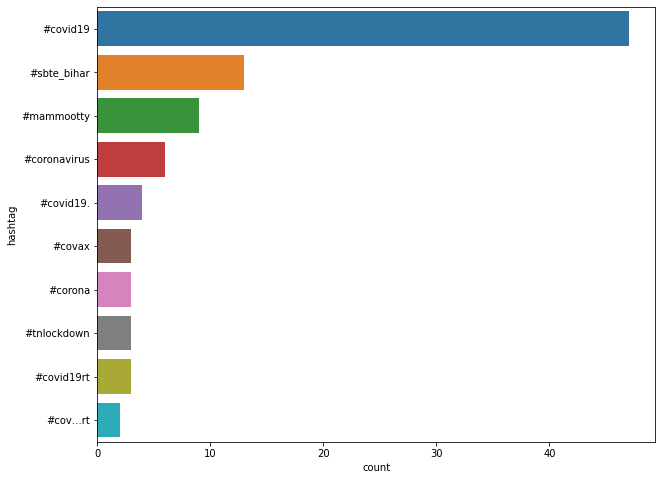

5


In [9]:
# import libraries to visualize the results
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
get_ipython().run_line_magic('matplotlib', 'inline')
count = 0
while count < 5:
    
    time.sleep(5)
    top_10_tags = sqlContext.sql( 'Select hashtag, count from tweets' )
    top_10_df = top_10_tags.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="hashtag", data=top_10_df)
    plt.show()
    count = count + 1
    print(count)